In [3]:
import pandas as pd
import re


df = pd.read_csv("logbook_assignment1.csv")
df.info()
df.head()


C:\Users\ariel\AppData\Local\Temp\ipykernel_16528\3042648664.py:5: DtypeWarning: Columns (3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("logbook_assignment1.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174870 entries, 0 to 1174869
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   date_fueled      1125665 non-null  object
 1   date_captured    1174870 non-null  object
 2   odometer         1025716 non-null  object
 3   gallons          1100660 non-null  object
 4   cost_per_gallon  1094110 non-null  object
 5   total_spent      1100660 non-null  object
 6   mpg              1100660 non-null  object
 7   miles            146274 non-null   object
 8   user_url         1174870 non-null  object
dtypes: object(9)
memory usage: 80.7+ MB


,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url
0,"Cooling System, Heating System, Lights, Spark ...",Apr 7 2022,"73,370",NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...
1,Nov 7 2012,Aug 30 2016,"11,983",12.120,$5.599,$67.86,31.6,NaN,https://www.somewebsite.com/bmw/x3/2009/461150
2,Sep 22 2012,Sep 28 2012,"98,233",7.991,£5.45,£43.53,28.5,NaN,https://www.somewebsite.com/mercedes-benz/e300...
3,May 4 2019,May 4 2019,"163,802",10.575,£5.11,£54.00,46.8,NaN,https://www.somewebsite.com/bmw/320d/2010/247233
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4,https://www.somewebsite.com/honda/passport/201...


In [4]:
#1.1 Cleaning:Date Fields
from dateutil.parser import parse
import warnings
from dateutil.parser._parser import UnknownTimezoneWarning

warnings.filterwarnings("ignore", category=UnknownTimezoneWarning)

#returns true if the entry is in a date format 
def validdate(s):
    if not isinstance(s, str) or not s.strip():
        return False
    try:
        parse(s, dayfirst=False,yearfirst=False,fuzzy=False)
        return True
    except Exception:
        return False

total = len(df)
invalid = (~df["date_fueled"].map(validdate)).sum()
invalidtotal= (invalid / total) * 100
print(f"Total dates: {total}")
print(f"Invalid dates: {invalid}")
print(f"Percentage of invalid dates: {invalidtotal:.3f}%")


Total dates: 1174870
Invalid dates: 135137
Percentage of invalid dates: 11.502%


In [5]:
#1.2

fueled_list = df["date_fueled"].astype(str).tolist() #convert the 'date_fueled' column to a list of strings
captured_list = df["date_captured"].astype(str).tolist()
#keeps track of how many rows we fix
replaced_count = 0

for i in range(len(fueled_list)):
    if not validdate(fueled_list[i]):    #check if current fueled val is invalid
        if validdate(captured_list[i]):      #if fueled is invalid, check if captured is valid
            fueled_list[i] = captured_list[i]    #If captured is valid, replace fueled with captured/replace with proxy 
            replaced_count += 1 #increase the counter since we fixed one row
#update the DataFrame with the fixed fueled_lis
df["date_fueled"] = fueled_list

print(f"Rows filled from date_captured: {replaced_count}") #replacements made
print("valid fueled:", df["date_fueled"].map(validdate).sum()) #entries in the final date_fueled column are valid
print("valid captured:", df["date_captured"].map(validdate).sum())#entries in the date_captured column are valid




Rows filled from date_captured: 135137
valid fueled: 1174870
valid captured: 1174870


In [15]:
#1.3

df["date_fueled_dt"] = pd.to_datetime(df["date_fueled"], errors="coerce", dayfirst=False)

#count invalids (NaT)
total = len(df)
nat_count = df["date_fueled_dt"].isna().sum()
print(f"entries converted to NaT: {nat_count} ({nat_count/total:.2%})")




entries converted to NaT: 2073 (0.18%)


In [17]:

#remove later
mask_validator_ok = df["date_fueled"].map(validdate)
mask_pandas_nat   = df["date_fueled_dt"].isna()
off_by_pandas = df.loc[mask_validator_ok & mask_pandas_nat, "date_fueled"].head(20)
print("Validator OK but pandas NaT (samples):")
print(off_by_pandas.to_list())

print(df.loc[mask_validator_ok & mask_pandas_nat, "_date_fueled_raw"].head(20).to_list())


print({
    "validator_invalid": int((~mask_validator_ok).sum()),
    "pandas_NaT": int(mask_pandas_nat.sum()),
    "validator_ok_but_pandas_NaT": int((mask_validator_ok & mask_pandas_nat).sum())
})


Validator OK but pandas NaT (samples):
['95', '46.6', '7.7', '21.0\r\n', '217,166', '4993', '288.4', '42.0', '39.2', '23.1', '19.2', '17.5', '200413', '8 hours', '281.8', '19.7', '419', 'Tuesday', '28.2', '22.7']


KeyError: '_date_fueled_raw'

In [20]:
#1.4
lower = pd.Timestamp("2005-01-01")
upper= pd.Timestamp.today().normalize()  #today's date

#True if inside the valid range)
mask = df["date_fueled_dt"].between(lower, upper, inclusive="both")

#filter the dataframe
before = len(df)
df = df[mask].copy()
after = len(df)

#many were dropped
print(f"Removed rows outside [{lower.date()} .. {upper.date()}]: {before - after}")
print(f"Rows remaining: {after}")




Removed rows outside [2005-01-01 .. 2025-09-02]: 2643
Rows remaining: 1172227


Date range (after cleaning): 2005–2025
Peak year: 2021  (count = 340217)
Share of records in the last 5 years: 45.1%
Most common month number: 3 (1=Jan, 12=Dec)


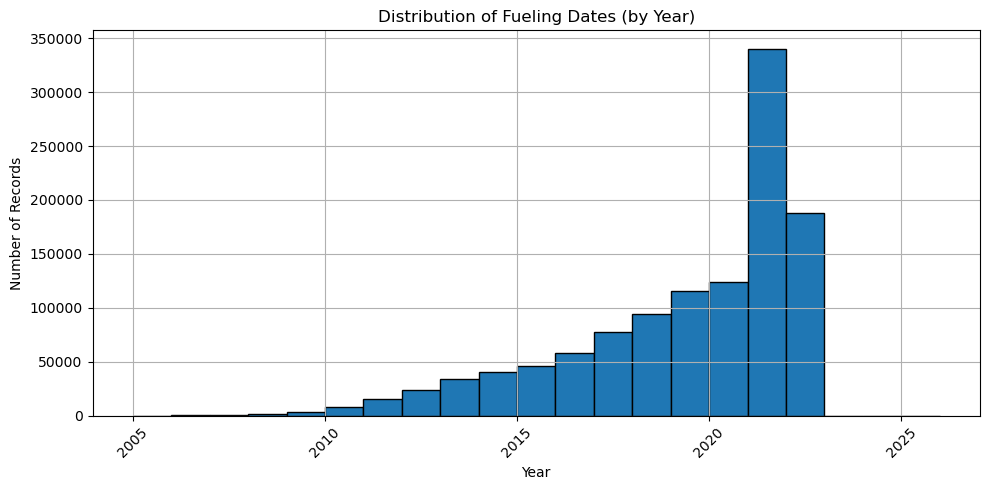

In [26]:
#1.5
import pandas as pd
import matplotlib.pyplot as plt

#Make sure we have a datetime column
DATE_COL = "date fueled" if "date fueled" in df.columns else "date_fueled"
if "date_fueled_dt" not in df.columns:
    df["date_fueled_dt"] = pd.to_datetime(df[DATE_COL], errors="coerce", dayfirst=False)

#keep only valid datetimes
dates = df["date_fueled_dt"].dropna()

years = dates.dt.year
months = dates.dt.month

year_counts = years.value_counts().sort_index()
month_counts = months.value_counts().sort_index()

start_year = int(years.min()) if not years.empty else None
end_year   = int(years.max()) if not years.empty else None

top_year = int(year_counts.idxmax()) if not year_counts.empty else None
top_year_n = int(year_counts.max()) if not year_counts.empty else 0

#last 5 yrs
if not years.empty:
    last5_mask = years >= (years.max() - 4)
    share_last5 = last5_mask.mean() * 100
else:
    share_last5 = 0.0

peak_month = int(month_counts.idxmax()) if not month_counts.empty else None
print(f"Date range (after cleaning): {start_year}–{end_year}")
print(f"Peak year: {top_year}  (count = {top_year_n})")
print(f"Share of records in the last 5 years: {share_last5:.1f}%")
print(f"Most common month number: {peak_month} (1=Jan, 12=Dec)")


if not years.empty:
    plt.figure(figsize=(10, 5))
    # use integer bins from min to max (+1 to close the last bin)
    bins = range(int(years.min()), int(years.max()) + 2)
    years.hist(bins=bins, edgecolor="black")
    plt.title("Distribution of Fueling Dates (by Year)")
    plt.xlabel("Year")
    plt.ylabel("Number of Records")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


